In [42]:
import os
import glob
import cv2              # OpenCV，用来读图、处理图像
import matplotlib.pyplot as plt  # 用来在 notebook 里显示图片
import numpy as np

In [43]:
img_dir = r"./stainimg" 
# 支持的图片后缀，可以按需增删
ext = "*.bmp"
# 收集所有图片路径到一个列表里
img_paths = []
img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
# 可以排序一下，方便查看
img_paths = sorted(img_paths)
print(f"在文件夹 {img_dir} 中共找到 {len(img_paths)} 张图片")

在文件夹 ./stainimg 中共找到 36 张图片


第一张图片路径： ./stainimg\cam2_20230303225959586.bmp


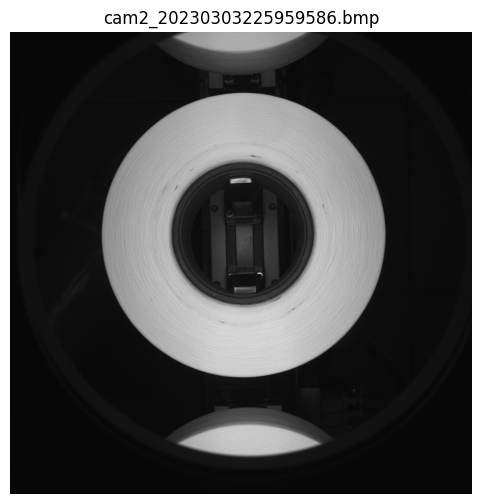

Circles (x, y, r):
[[2588 2253 1575]
 [2581 2233  786]]
Img shape: (5120, 5120, 3)


In [44]:
from ed_detect import run_edge_detection

first_img_path = img_paths[10]
print("第一张图片路径：", first_img_path)

# 用 OpenCV 读取图片（默认是 BGR 通道顺序）
img_bgr = cv2.imread(first_img_path, cv2.IMREAD_COLOR)

if img_bgr is None:
    raise RuntimeError("读取图片失败，请检查文件是否存在或路径是否包含中文导致的问题。")

# OpenCV 是 BGR 排列，而 Matplotlib 按 RGB 显示，需要转换一下
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 在 notebook 中显示这张图
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title(os.path.basename(first_img_path))
plt.axis("off")
plt.show()

# 先跑一遍你封装好的边缘检测
Img, Img_gray, Edges, Circles = run_edge_detection(first_img_path)

print("Circles (x, y, r):")
print(Circles)
print("Img shape:", Img.shape)

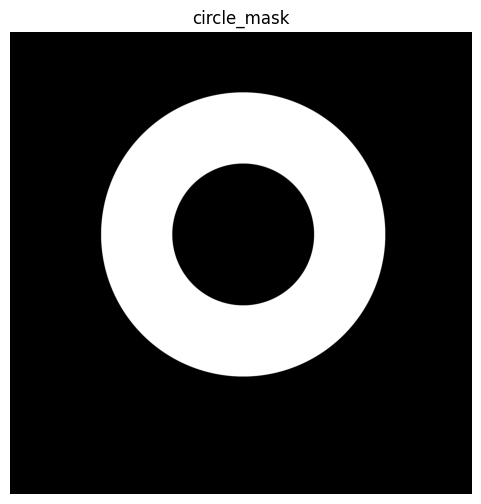

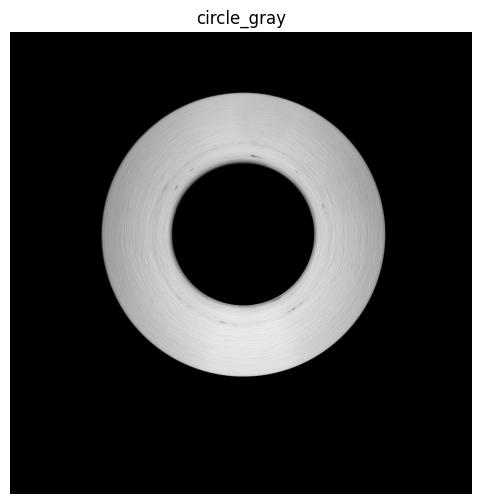

In [45]:
def build_ring_mask(gray_img: np.ndarray, circles: np.ndarray) -> np.ndarray:
    """
    根据 Hough 检测到的圆，构造环形掩膜。
    circles: (N,3), 每行 (x, y, r)，期望 N=2（外+内）
    返回: mask (H, W), uint8, 环形区域为 255，其余为 0
    """
    h, w = gray_img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if circles is None or len(circles) == 0:
        raise RuntimeError("没有检测到任何圆，无法构造环形掩膜。")

    # 按半径从大到小排序，最大视作外圆，次大视作内圆
    circles_sorted = sorted(circles.tolist(), key=lambda c: c[2], reverse=True)
    if len(circles_sorted) == 1:
        # 极端情况只有一个圆，这里暂时直接报错，也可以后面再想策略
        raise RuntimeError("只检测到一个圆，建议调整 Hough 参数。")

    (xo, yo, ro) = circles_sorted[0]   # outer
    (xi, yi, ri) = circles_sorted[1]   # inner

    # 用外圆圆心作为统一圆心（两者通常很接近）
    cx = int(round((xo + xi) / 2))
    cy = int(round((yo + yi) / 2))
    r_outer = int(max(ro, ri))
    r_inner = int(min(ro, ri))

    # 先填满大圆
    cv2.circle(mask, (cx, cy), r_outer, 255, thickness=-1)
    # 再抠掉内圆
    cv2.circle(mask, (cx, cy), r_inner, 0, thickness=-1)

    return mask

mask_ring = build_ring_mask(Img_gray, Circles)

plt.figure(figsize=(6, 6))
plt.imshow(mask_ring, cmap="gray")
plt.title("circle_mask")
plt.axis("off")
plt.show()

# 用掩膜抠出环形区域看看
ring_gray = cv2.bitwise_and(Img_gray, Img_gray, mask=mask_ring)

plt.figure(figsize=(6, 6))
plt.imshow(ring_gray, cmap="gray")
plt.title("circle_gray")
plt.axis("off")
plt.show()


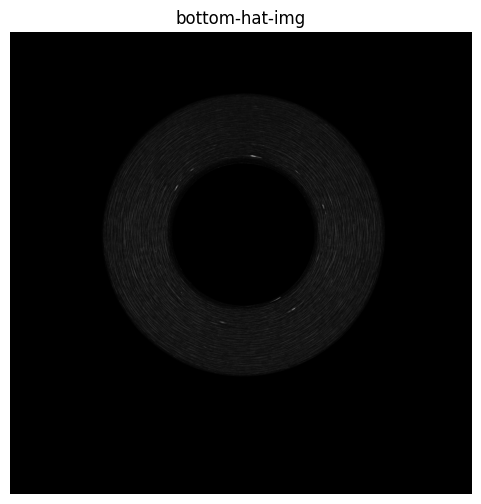

In [46]:
# 只在环形区域考虑，外面置 0
ring_gray_for_morph = ring_gray.copy()

# 结构元素大小可以根据缺陷大小调整，一般稍微比缺陷大一些
kernel_size = 35    # 你可以后面试试 21, 31, 41 等不同值
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# 闭运算
closing = cv2.morphologyEx(ring_gray_for_morph, cv2.MORPH_CLOSE, kernel)

# bottom-hat = closing - 原图
bottom_hat = cv2.subtract(closing, ring_gray_for_morph)

plt.figure(figsize=(6, 6))
plt.imshow(bottom_hat, cmap="gray")
plt.title("bottom-hat-img")
plt.axis("off")
plt.show()


bottom-hat 均值: 11.186470433442352 标准差: 6.222152449372796
使用阈值: 36.07508023093354


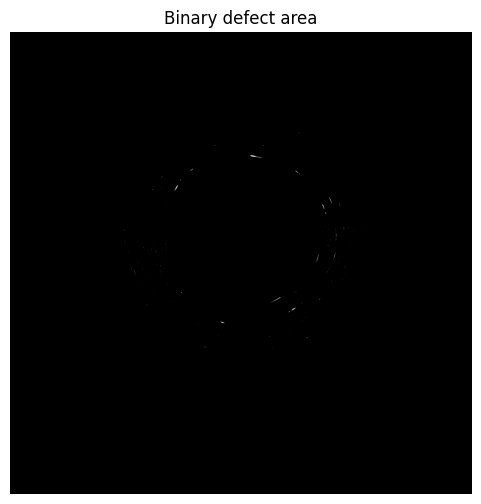

In [50]:
# 只统计环形区域内 bottom-hat 的数值
mask_bool = mask_ring > 0
values = bottom_hat[mask_bool]

mean_val = float(values.mean())
std_val = float(values.std())
print("bottom-hat 均值:", mean_val, "标准差:", std_val)

k = 4.0  # 可以从 1.5 ~ 3.0 之间尝试
thresh_val = mean_val + k * std_val
print("使用阈值:", thresh_val)

_, defect_bin = cv2.threshold(
    bottom_hat, thresh_val, 255, cv2.THRESH_BINARY
)

# 再和环形掩膜相与，确保只保留环里
defect_bin = cv2.bitwise_and(defect_bin, defect_bin, mask=mask_ring)

plt.figure(figsize=(6, 6))
plt.imshow(defect_bin, cmap="gray")
plt.title("Binary defect area")
plt.axis("off")
plt.show()


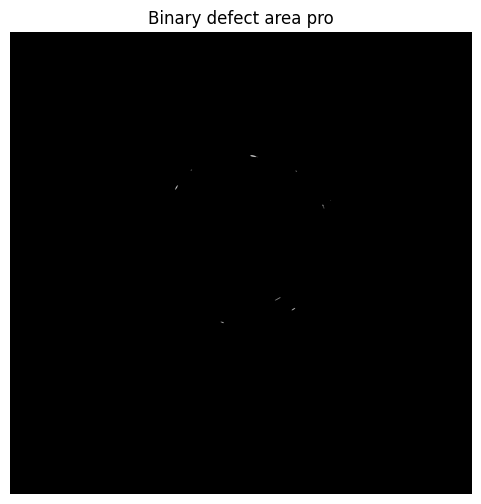

In [51]:
# 去除孤立小噪点 & 填补小孔洞
kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

defect_clean = cv2.morphologyEx(defect_bin, cv2.MORPH_OPEN, kernel_small, iterations=1)
defect_clean = cv2.morphologyEx(defect_clean, cv2.MORPH_CLOSE, kernel_small,iterations=1)

plt.figure(figsize=(6, 6))
plt.imshow(defect_clean, cmap="gray")
plt.title("Binary defect area pro")
plt.axis("off")
plt.show()


检测到连通域数量（含背景）: 752
已保存缺陷标记结果到： out\cam2_20230303225959586_defect.bmp
通过面积筛选后的缺陷数量: 14
{'index': 14, 'bbox': (2662, 1366, 129, 30), 'center': (2710, 1377), 'area': 896}
{'index': 24, 'bbox': (1996, 1513, 36, 27), 'center': (2014, 1525), 'area': 143}
{'index': 25, 'bbox': (3165, 1535, 32, 28), 'center': (3177, 1547), 'area': 159}
{'index': 44, 'bbox': (1823, 1691, 44, 67), 'center': (1843, 1724), 'area': 490}
{'index': 62, 'bbox': (3538, 1831, 30, 70), 'center': (3552, 1864), 'area': 257}
{'index': 83, 'bbox': (3463, 1908, 20, 53), 'center': (3471, 1932), 'area': 281}
{'index': 104, 'bbox': (3496, 1995, 8, 26), 'center': (3499, 2008), 'area': 86}
{'index': 199, 'bbox': (3613, 2231, 5, 34), 'center': (3614, 2249), 'area': 67}
{'index': 323, 'bbox': (3591, 2453, 16, 42), 'center': (3598, 2475), 'area': 106}
{'index': 326, 'bbox': (3396, 2458, 30, 87), 'center': (3409, 2504), 'area': 248}
{'index': 619, 'bbox': (2902, 2940, 98, 51), 'center': (2957, 2962), 'area': 435}
{'index': 669, 'bbox'

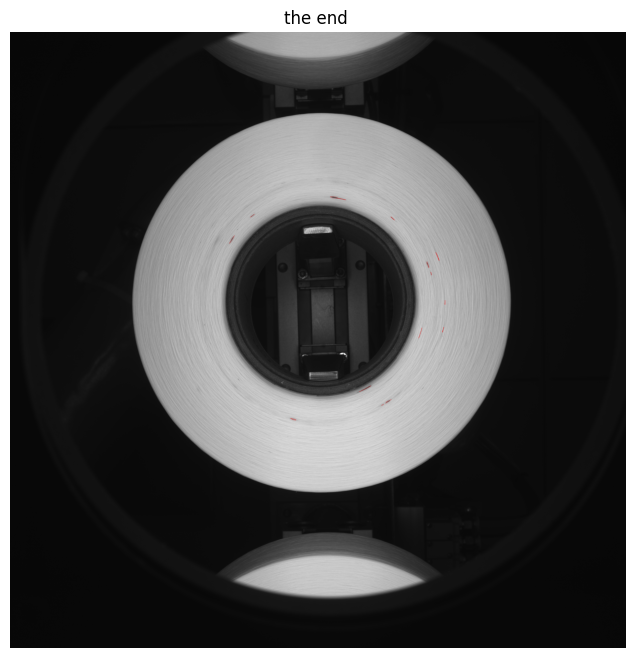

In [56]:
# 连通域分析
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    defect_bin, connectivity=8
)

print("检测到连通域数量（含背景）:", num_labels)

# stats: (num_labels, 5) → [x, y, w, h, area]
# 第 0 行是背景，其余是候选缺陷
min_area = 50      # 小于这个面积认为是噪声
max_area = 100000   # 过大的区域可能是误检，你可以根据实际调

vis = Img.copy()
defect_list = []

# 用来保存所有“通过面积筛选的缺陷区域”的 mask
mask_defects = np.zeros_like(defect_clean, dtype=np.uint8)

for i in range(1, num_labels):  # 从 1 开始跳过背景
    x, y, w, h, area = stats[i]

    if area < min_area or area > max_area:
        continue

    cx, cy = centroids[i]
    defect_list.append({
        "index": i,
        "bbox": (int(x), int(y), int(w), int(h)),
        "center": (int(cx), int(cy)),
        "area": int(area)})

    # 把该连通域对应的像素置为 255，累积到总的缺陷 mask 上
    mask_defects[labels == i] = 255

# 从缺陷 mask 中提取“边缘像素”
# 形态学梯度
kernel_edge = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
edge_mask = cv2.morphologyEx(mask_defects, cv2.MORPH_GRADIENT, kernel_edge)

# 在原图上只对“边缘像素”上色：BGR 红色 (0, 0, 255)
vis[edge_mask == 255] = (0, 0, 255)

dir_name, file_name = os.path.split(first_img_path)
name, ext = os.path.splitext(file_name)
# ext 本来就是 ".bmp"，这里沿用原格式
out_dir = "out"
out_path = os.path.join(out_dir, f"{name}_defect{ext}")

# 用 OpenCV 按 bmp 格式保存，像素尺寸保持不变
ok = cv2.imwrite(out_path, vis)
if ok:
    print("已保存缺陷标记结果到：", out_path)
else:
    print("保存失败，请检查路径或权限")

print("通过面积筛选后的缺陷数量:", len(defect_list))
for d in defect_list:
    print(d)

# 显示标记结果
vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(vis_rgb)
plt.title("the end ")
plt.axis("off")
plt.show()
